In [50]:
%matplotlib inline
from jax.config import config
config.update("jax_enable_x64", True) 

import jax
import jax.numpy as np

import pylab as plt
import imageio
import os
import numpy as onp
from skimage.transform import rescale, resize, downscale_local_mean
import pandas as pd
import time
import scipy
from sklearn import metrics
#this note book uses all the old ppl

# Data Pre-Processing

In [2]:
#to change directory
os.chdir("/mnt/c/Users/Joyce/Downloads/DSA4212/datasets/")
os.getcwd()

'/mnt/c/Users/Joyce/Downloads/DSA4212/datasets'

In [3]:
#load attributes csv file
attribute = pd.read_csv("celeba.csv")

#attribute.keys()

In [4]:
#read the image file
path = "img_celeba_small"
all_img = [f for f in os.listdir(path) 
                 if os.path.isfile(os.path.join(path, f)) 
                 and f.endswith(".jpg")]
nb_img = len(all_img)
print("Number of images:", nb_img)

#let us keep only the relevant rows in attributes
attribute = attribute[:20000]

Number of images: 20000


## Creating training and validation datasets

In [6]:
# select first 15000 rows for training dataset
train = attribute[:15000]
train = train['Young'] #just have the index and whether is old or young

# select last 5000 rows for test dataset
test = attribute[15000:20000]
test = test['Young']

In [7]:
is_Young = train==1
is_Old = train==-1

# subset training set by young/old
train_y = train[is_Young] 
train_o = train[is_Old]

len(train_o)

3331

In [182]:
#in the 15000 training data, 3331 are old, so we take all 3331 old and 3331 from young
#want training set to have 5330 observations, and validation set to have 1332 observations
    #for training, want 2665 old and 2665 young, and
    #for validation want 666 young and 666 old

In [8]:
# sample 3331 observations from all young data in training set
onp.random.seed(0)
y_pindex = onp.random.choice(len(train_y), len(train_o), replace=False)
o_pindex = onp.asarray(list(range(3331)))

In [9]:
train_n = 2665
val_n = len(train_o) - train_n

# select prelim training & validation data
ptrain_y = train_y.iloc[y_pindex[:train_n]]
pval_y = train_y.iloc[y_pindex[train_n:]]

ptrain_o = train_o.iloc[o_pindex[:train_n]]
pval_o = train_o.iloc[o_pindex[train_n:]]

# collate prelim training data (3k obs, 1.5k each class)
ptrain = ptrain_y.append(ptrain_o)
ptrain = ptrain.sort_index()

# collate prelim test data (1k obs, .5k each class)
pval = pval_y.append(pval_o)
pval = pval.sort_index()

## Loading images

The images were loaded in grayscale with an initial size of 100 by 100 pixels. The pixel intensity was then rescaled to [0,1]. To remove parts of the image irrelevant to a person's age (outside of the face), the images were cropped to only include the range [25:85, 20:80]. The final images used for analysis are 60 by 60 pixels.

We did greyscale so as to reduce the number of dimensions

In [10]:
res = 100
#crop_dim = [25:85,20:80]

# load the images from the prelim training set
ntrain_img = len(ptrain)
ptrain_ind = ptrain.index.values
ptrain_img = onp.zeros((ntrain_img,60,60))

for k in range(ntrain_img):
    im = imageio.imread(os.path.join(path, all_img[ptrain_ind[k]])).astype(float)
    im = resize(im, (res,res))
    im = onp.mean(im, axis=2)
    im = im/255.
    im = im[25:85,20:80]
    ptrain_img[k,:,:] = im
    


In [11]:
# load the images from the prelim validation set
nval_img = len(pval)
pval_ind = pval.index.values
pval_img = onp.zeros((nval_img,60,60))

for k in range(nval_img):
    im = imageio.imread(os.path.join(path, all_img[pval_ind[k]])).astype(float)
    im = resize(im, (res,res))
    im = onp.mean(im, axis=2)
    im = im/255.
    im = im[25:85,20:80]
    pval_img[k,:,:] = im

In [12]:
#load the images from the test set
ntest_img = len(test)
test_ind = test.index.values
test_img = onp.zeros((ntest_img,60,60))

for k in range(ntest_img):
    im = imageio.imread(os.path.join(path,all_img[test_ind[k]])).astype(float)
    im = resize(im,(res,res))
    im = onp.mean(im,axis=2)
    im = im/255.
    im = im[25:85,20:80]
    test_img[k,:,:] = im

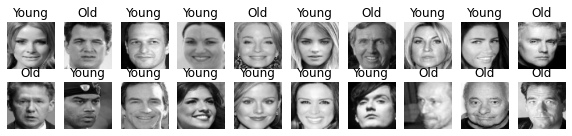

In [13]:
# test if the subsetting was successful for training set
plt.figure(figsize=(10,2))
for k in range(20):
    im = ptrain_img[k]
    plt.subplot(2,10,k+1)
    plt.imshow(im/255., cmap='gray')
    plt.axis("off")
    
    is_Young = ptrain.iloc[k]
    if is_Young == 1:
        plt.title("Young")
    else:
        plt.title("Old")

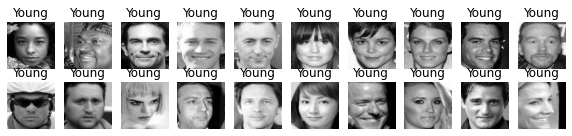

In [14]:
# test if the subsetting was successful for validation
plt.figure(figsize=(10,2))
for k in range(20):
    im = pval_img[k]
    plt.subplot(2,10,k+1)
    plt.imshow(im/255., cmap='gray')
    plt.axis("off")
    
    is_Young = pval.iloc[k]
    if is_Young == 1:
        plt.title("Young")
    else:
        plt.title("Old")

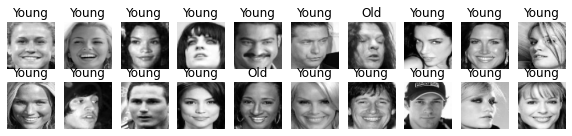

In [15]:
# test if the subsetting was successful for test set
plt.figure(figsize=(10,2))
for k in range(20):
    im = test_img[k]
    plt.subplot(2,10,k+1)
    plt.imshow(im/255., cmap='gray')
    plt.axis("off")
    
    is_Young = test.iloc[k]
    if is_Young == 1:
        plt.title("Young")
    else:
        plt.title("Old")

`ptrain` is a 1x3000 array with the indicator values {-1, 1} for old and young. `ptrain_img` is a 3000 x 60 x 60 array that contains the relevant images for the preliminary training data. 

`ptest` is a 1x3000 array with the indicator values {-1, 1} for old and young. `ptest_img`is a 1000 x 60 x 60 array that contains the relevant images for the preliminary validation data. 

In [16]:
len(ptrain)

5330

In [17]:
data_train = ptrain_img.reshape(5330, 60*60)
y_train = ptrain.to_numpy(copy=True)

data_val = pval_img.reshape(1332, 60*60)
y_val = pval.to_numpy(copy=True)

data_test = test_img.reshape(5000,60*60)
y_test = test.to_numpy(copy=True) #to convert from pandas dataframe to numpy array

# My part

### Model 1 : Naive model

In [195]:
#given that 78% of the dataset is young, we will build a naive model where we just predict all the pictures to be young
prediction_naive = (onp.arange(5000)*0)+1 #list of 5000 of all 1's 


In [196]:
#prediction accuracy:
sum(prediction_naive == y_test )/5000

#naive model has a prediction accuracy of 78.58% on the test data set.

0.7858

### Model 2: Logistic regression with naive gradient descent


In [22]:
#define functions
def prediction_single(beta, x): #log prob for a single x
    """ beta is a vector of dimension 3600, and x as well """
    proba = 1. / (1. + np.exp(-np.dot(beta, x)))
    return proba

#make a prediction on a whole dataset, dont need to map for beta since beta is the same for all x,just need to map to the x
prediction_data = jax.vmap(prediction_single, in_axes=(None,0))

def loss_single(beta,x,y):#loss for a single exmaple
    """
    beta: vector of dimension 3600
    x: vector of dimension 3600
    y: a number that equals -1 or 1
    """
    return np.log(1. + np.exp(-y * np.dot(beta, x)))

#compute the loss on. whole dataset
loss_dataset = jax.vmap(loss_single, in_axes=(None,0,0))

def loss(beta, data, y): #loss for the whole dataset, is just the sum of all the losses at each datapoint
    """ compute the mean of all the individual losses """
    list_of_all_losses = loss_dataset(beta, data, y)
    return np.mean(list_of_all_losses)

def accuracy(beta, data, y): #we use our validation set here, we test our algo see how well it predicts on the validation set
    pred = prediction_data(beta, data)
    threshold = 0.5
    prediction_binary = (pred > 0.5).astype(int)  #equals 1 if pred > threshold and 0 otherwise
    prediction_sign = 2*(prediction_binary - 0.5) #equals 1 if pred > threshold and -1 otherwise
    #we use prediction sign bc we want -1 and 1 innstead of 1 and 0
    return np.mean(prediction_sign == y) #want to see how many is correct

grad_loss = jax.jit(jax.grad(loss,argnums = 0)) #to compute gradient of the loss function

In [23]:
onp.random.seed(1)
beta_init = onp.random.normal(0,0.1,size=3600)
beta_init

array([ 0.16243454, -0.06117564, -0.05281718, ...,  0.02257672,
       -0.10890871,  0.12800581])

In [24]:
onp.random.seed(2)
beta_init2 = onp.random.normal(0,0.1,size=3600)

In [25]:
n_iter = 3000
learning_rate = 0.04
loss_history_train=[]
loss_history_val = []
acc_train_list = []
acc_val_list = []
beta = onp.copy(beta_init)
beta_min = onp.copy(beta_init2)
current_lowestloss_update = []

current_lowest_loss = loss(beta_min,data_val,y_val) #on the validation set for later comparison

for k in range(n_iter):
    gradient = grad_loss(beta,data_train,y_train)
    beta = beta-learning_rate*gradient
    current_loss_train = loss(beta,data_train,y_train)
    current_loss_val = loss(beta,data_val,y_val)
    accuracy_train = accuracy(beta,data_train,y_train)
    accuracy_val = accuracy(beta,data_val,y_val)
    
    if current_loss_val <= current_lowest_loss:
        beta_min = beta
        current_lowest_loss = current_loss_val
        current_lowestloss_update.append(current_lowest_loss)
    
    acc_train_list.append(accuracy_train)
    acc_val_list.append(accuracy_val)
    loss_history_train.append(current_loss_train)
    loss_history_val.append(current_loss_val)


/usr/local/lib/python3.6/dist-packages/jax/lib/xla_bridge.py:123: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [38]:
beta_min

array([-0.04167578, -0.00562668, -0.21361961, ..., -0.02856757,
        0.0423136 , -0.05155589])

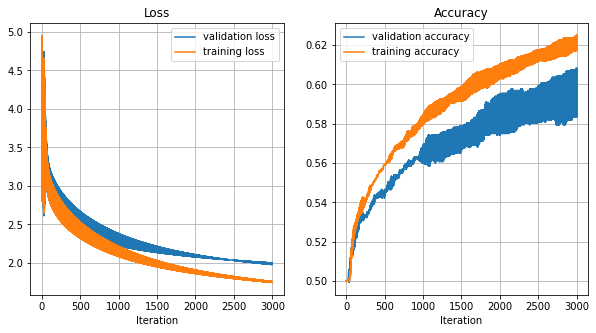

In [47]:

#plots to show loss and accuracy
plt.figure(figsize=(10,5)) #plot the loss
plt.subplot(1,2,1)
plt.plot(loss_history_val,label = "validation loss")
plt.plot(loss_history_train,label = "training loss")
plt.grid(True)
plt.title("Loss")
plt.xlabel("Iteration")
plt.legend(loc = "upper right")

plt.subplot(1,2,2)
plt.plot(acc_val_list,label = "validation accuracy")
plt.plot(acc_train_list,label = "training accuracy")
plt.grid(True)
plt.title("Accuracy")
plt.xlabel("Iteration")
plt.legend(loc = "upper left")

    
    

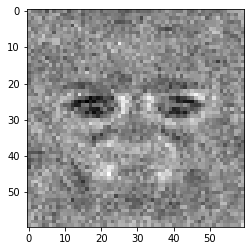

In [45]:
#plot the betas
plt.imshow(beta.reshape(60,60),cmap = "gray")


In [30]:
#this is the latest trained beta rom naive gradient descent!
beta_model1_latest = onp.copy(beta)

In [31]:
beta_model1_latest

array([ 0.1607424 , -0.0731102 , -0.09274938, ...,  0.09875679,
        0.03570336,  0.43262347])

In [46]:
#now to test on the test set:
accuracy(beta_model1_latest,data_test,y_test)
#81.32% accuracy on the test set, better than our naive model

DeviceArray(0.8132, dtype=float64)

In [32]:
#using the beta that led to minimum validation loss
beta_model1_min = onp.copy(beta_min)

In [33]:
beta_model1_min

array([-0.04167578, -0.00562668, -0.21361961, ..., -0.02856757,
        0.0423136 , -0.05155589])

In [35]:
accuracy(beta_model1_min,data_test,y_test)

DeviceArray(0.2204, dtype=float64)

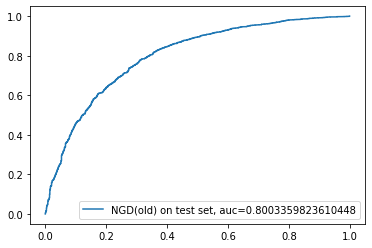

In [53]:
#auc curve
y_pred_proba = prediction_data(beta_model1_latest,data_test)
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="NGD(old) on test set, auc="+str(auc))
plt.legend(loc=4)
plt.show()


In [61]:
#try diff thresholds
def accuracy1(beta, data, y,threshold): #we use our validation set here, we test our algo see how well it predicts on the validation set
    pred = prediction_data(beta, data)
    prediction_binary = (pred > threshold).astype(int)  #equals 1 if pred > threshold and 0 otherwise
    prediction_sign = 2*(prediction_binary - 0.5) #equals 1 if pred > threshold and -1 otherwise
    #we use prediction sign bc we want -1 and 1 innstead of 1 and 0
    return np.mean(prediction_sign == y) #want to see how many is correct

t = list(range(1,10))

for i in t:
    print(accuracy1(beta_model1_latest,data_test,y_test,i/10))

0.8036
0.808
0.8132
0.813
0.8132
0.8152
0.8178
0.8196
0.8154


### Model 3: Logistic regression with backtracking

In [ ]:
onp.random.seed(1)
beta_init = onp.random.normal(0,0.1,size=3600)
beta = onp.copy(beta_init)

onp.random.seed(2)
beta_init_min =  onp.random.normal(0,0.1,size=3600)

In [ ]:
#backtracking:
n_iter = 500
learning_rate = 10
loss_val3 = []
loss_train3 = []
acc_train_list3 =[]
acc_val_list3 = []
alpha= 0.5

beta_min = onp.copy(beta_init_min)
loss_val = loss(beta_min,data_val,y_val)

for k in range(n_iter):
    #need to first compute descent direction
    gradient = grad_loss(beta,data_train,y_train)
    descent_direction = -gradient
    
    #adaptive learning rate
    learning_rate = learning_rate*3
    current_loss = loss(beta,data_train,y_train)
    while loss(beta+learning_rate*descent_direction,data_train,y_train)> current_loss+alpha*learning_rate*np.dot(descent_direction,gradient):
        learning_rate = learning_rate/2.
    
    #now do update:
    beta = beta+learning_rate* descent_direction
    
    accuracy_train = accuracy(beta,data_train,y_train)
    accuracy_val = accuracy(beta,data_val,y_val)
    current_lost_val = loss(beta,data_val,y_val)
    current_lost_train = loss(beta,dat_train,y_train)
    
    if current_lost_val <=lost_val:
        beta_min=beta
        lost_val = current_lost_val
    
    acc_train_list3.append(accuracy_train)
    acc_val_list3.append(accuracy_val)
    loss_val3.append(current_loss_val)
    loss_train3.append(current_loss_train)


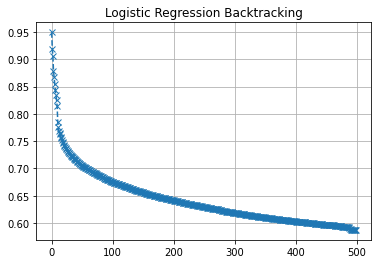

In [229]:
plt.plot(loss_history3,"--x")
plt.title("Logistic Regression Backtracking")
plt.grid(True)

In [230]:
beta_model3 = onp.copy(beta)

In [231]:
#to test on test set:
accuracy(beta_model3,data_test,y_test)
#67.6%% not as good as just naive descent 

DeviceArray(0.676, dtype=float64)

### Model 5?: Logistic regression with sgd and momentum

In [61]:
onp.random.seed(1)
beta_init = onp.random.normal(0,0.1,3600)
grad_loss = jax.jit(jax.grad(loss))

onp.random.seed(2)
beta_init_min = onp.random.normal(0,0.1,3600)


In [65]:
len(data_val)

2663

In [70]:
#basic naive gradient desent
n_iter = 500
learning_rate = 0.08
loss_train5 = []
loss_val5 = []
beta = onp.copy(beta_init)

beta_min = onp.copy(beta_init_min)
loss_val = loss(beta_min,data_val,y_val) #initial lowest loss on validation set for later comparison

n_epoch = 60
batch_size = 1500
mov_avg = 0.95 #for momentum

gradient = grad_loss(beta,data_train,y_train) #initilzae the graident

for epoch in range(n_epoch):
    if epoch % 10 == 0 and epoch >= 1:    #let us divide the learning by 2 every 10 epoch
        learning_rate = learning_rate/2.
    
    for k in range(2663 // batch_size): #division but u take the quotient, so is number of batch per epoch
        index = onp.arange(k*batch_size, (k+1)*batch_size)% 2663
        
        gradient_local = grad_loss(beta,data_train[index],y_train[index]) #approx of gradient 
        
        gradient = gradient*mov_avg + (1-mov_avg)*gradient_local# now take into account the momentum part
        
        #gradient descent update:
        beta = beta-learning_rate*gradient
        current_loss_train = loss(beta,data_train[index],y_train[index])
        current_loss_val = loss(beta,data_val[index],y_val[index])
        
        loss_train5.append(current_loss_train)
        loss_val5.append(current_loss_val)
        
        if current_loss_val<=loss_val:
            beta_min =beta
            loss_val = current_loss_val

Text(0.5, 1.0, 'Stochastic Gradient Descent')

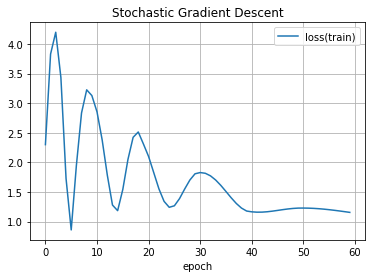

In [71]:
plt.plot(loss_train5, label="loss(train)")
plt.legend()
plt.grid(True)
plt.xlabel("epoch")
plt.title("Stochastic Gradient Descent")




In [239]:
beta_model5 = onp.copy(beta)

In [ ]:
beta_model5

In [242]:
#to predict on test:
accuracy(beta_model5,data_test,y_test)
#67.6%, worse than naive model

DeviceArray(0.676, dtype=float64)

## Model 6?: regularized logistic regression


# Optimisation

Logistic regression loss function with penalty: (penalty term not included for now)
$$ \frac{1}{N} \, \sum_{i=1}^N \log(1 + \exp(-y_i \, \langle \beta, x_i \rangle)) + \frac{1}{N} \| \beta \|^2$$

Logistic probability:
$$P(y=1 | x) = \frac{1}{1 + \exp(- \langle \beta, x \rangle)}$$

In [158]:
def prediction_single(beta, x):
    """ beta is a vector of dimension 10000, and x as well """
    proba = 1. / (1. + np.exp(-np.dot(beta, x)))
    return proba

#make a prediction on a whole dataset
prediction_data = jax.vmap(prediction_single, in_axes=(None,0))

def loss_single(beta,x,y):
    """
    beta: vector of dimension 100*100
    x: vector of dimension 100*100
    y: a number that equals -1 or 1
    """
    return np.log(1. + np.exp(-y * np.dot(beta, x)))

#compute the loss on. whole dataset
loss_dataset = jax.vmap(loss_single, in_axes=(None,0,0))

def loss(beta, data, y):
    """ compute the mean of all the individual losses """
    list_of_all_losses = loss_dataset(beta, data, y)
    return np.mean(list_of_all_losses) #+ np.mean(abs(beta))

grad_loss = jax.jit(jax.grad(loss))

def accuracy(beta, data, y):
    pred = prediction_data(beta, data)
    threshold = 0.5
    prediction_binary = (pred > 0.5).astype(int)  #equals 1 if pred > threshold and 0 otherwise
    prediction_sign = 2*(prediction_binary - 0.5) #equals 1 if pred > threshold and -1 otherwise
    return np.mean(prediction_sign == y)

In [159]:
D = 60*60
beta_init = onp.random.normal(0., scale = 1./onp.sqrt(D), size=D)

## Gradient Descent

In [ ]:
n_iter = 500
learning_rate = 0.01
loss_history = []
acc_train_list = []
acc_val_list = []

beta = onp.copy(beta_init)

for k in range(n_iter):
    gradient = grad_loss(beta, data_train, y_train)
    beta = beta - learning_rate * gradient
    current_loss = loss(beta, data_train, y_train)
    
    accuracy_train = accuracy(beta, data_train, y_train)
    accuracy_val = accuracy(beta, data_val, y_val) 
    
    acc_train_list.append(accuracy_train)
    acc_val_list.append(accuracy_val)
    if k % 50 == 0:
        print("Loss:{0:.3f} \t Accuracy: {1:.3f}% / {2:.3f}%".format(current_loss, \
                                             100*accuracy_train,\
                                             100*accuracy_val))
    loss_history.append(current_loss)

## L-BFGS

In [160]:
def loss_wrapper(beta):
    """ only one argument """
    return loss(beta, data_train, y_train)

grad_loss_wrapper = jax.jit(jax.grad(loss_wrapper))    

def gradient_wrapper(beta):
    """output is a numpy array"""
    return onp.array(grad_loss_wrapper(beta))

In [161]:
loss_train_history = []  #to save the loss trajectory
loss_val_history = []  #to save the loss trajectory
acc_train_list = []
acc_val_list = []
time_history = []  #to save the compute time

beta = onp.copy(beta_init)

def save_traj(beta):
    """ a function that saves a few statistics for later analysis"""
    loss_train = loss(beta, data_train, y_train)
    loss_val = loss(beta, data_val, y_val)
    timing = time.time() - start
    #print("Time:{0:3f} \t Loss(train):{1:.3f} \t Loss(val):{2:.3f}".format(timing, loss_train, loss_val))
    time_history.append(timing)
    loss_train_history.append(loss_train)
    loss_val_history.append(loss_val)
    
    accuracy_train = accuracy(beta, data_train, y_train)
    accuracy_val = accuracy(beta, data_val, y_val) 
    
    acc_train_list.append(accuracy_train)
    acc_val_list.append(accuracy_val)

#run LBFGS
start = time.time()
traj = scipy.optimize.minimize(fun = loss_wrapper, #functino to minimize
                                x0 = onp.array(beta_init), #initial guess
                                method='L-BFGS-B',  #we want to use L-BFGS
                                jac=gradient_wrapper, #function that computes the gradient
                                callback=save_traj, #a function used to save some results for later pltting
                                options={"maxiter":100})  #maximum number of iteration

Text(0.5, 1.0, 'L-BFGS')

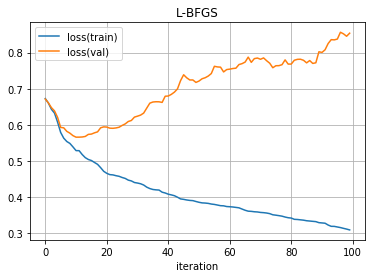

In [162]:
plt.plot(loss_train_history, label="loss(train)")
plt.plot(loss_val_history, label="loss(val)")
plt.legend()
plt.grid(True)
plt.xlabel("iteration")
plt.title("L-BFGS")

Text(0.5, 1.0, 'L-BFGS')

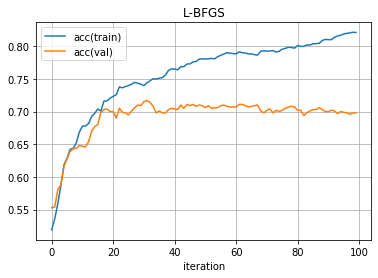

In [157]:
plt.plot(acc_train_list, label="acc(train)")
plt.plot(acc_val_list, label="acc(val)")
plt.legend()
plt.grid(True)
plt.xlabel("iteration")
plt.title("L-BFGS")

## Stochastic Gradient Descent + Momentum

In [171]:
n_epoch = 100
batch_size=100  #size of the mini-batch
beta = onp.copy(beta_init)
mov_avg_param = 0

learning_rate = 0.1
loss_train_history = []
loss_val_history = []

acc_train_list = []  #computed at the end of each epoch
acc_val_list = []    #computed at the end of each epoch

#initialize the gradient
gradient = grad_loss(beta, data_train, y_train)

start = time.time()
for epoch in range(n_epoch):
    #let us divide the learning by 2 every 10 epoch
    if epoch % 10 == 0 and epoch >= 1:
        learning_rate = learning_rate/2.
        
    for k in range(ntrain_img // batch_size):  #number of batch per epoch

        #first option
        #============
        #select at random "batch_size" random data point
        #index_ = onp.random.choice(train_data_size, batch_size, replace=False)

        #second option
        #============
        #consider the batches sequentially
        index_ = onp.arange(k*batch_size, (k+1)*batch_size) % ntrain_img
        gradient_local = grad_loss(beta, data_train[index_], y_train[index_])

        #moving average of the gradient
        gradient = gradient*mov_avg_param + (1-mov_avg_param)*gradient_local

        #gradient descent update
        beta = beta - learning_rate * gradient
    
    accuracy_train = accuracy(beta, data_train, y_train)
    accuracy_val = accuracy(beta, data_val, y_val) 
    acc_train_list.append(accuracy_train)
    acc_val_list.append(accuracy_val)
    
    loss_train = loss(beta, data_train, y_train)
    loss_val = loss(beta, data_val, y_val)
    loss_train_history.append(loss_train)
    loss_val_history.append(loss_val)
    
    timing = time.time() - start
    print("epoch:{0:.0f} \t time:{1:.0f} \t Loss(train):{2:.3f} \t Loss(val):{3:.3f}".format(epoch, 
                                                                                                  timing, 
                                                                                                  loss_train, 
                                                                                                  loss_val))

epoch:0 	 time:1 	 Loss(train):9.847 	 Loss(val):9.889
epoch:1 	 time:1 	 Loss(train):8.144 	 Loss(val):8.149
epoch:2 	 time:2 	 Loss(train):7.801 	 Loss(val):7.759
epoch:3 	 time:3 	 Loss(train):7.778 	 Loss(val):7.711
epoch:4 	 time:4 	 Loss(train):7.662 	 Loss(val):7.583
epoch:5 	 time:5 	 Loss(train):7.512 	 Loss(val):7.430
epoch:6 	 time:6 	 Loss(train):7.391 	 Loss(val):7.310
epoch:7 	 time:7 	 Loss(train):7.287 	 Loss(val):7.211
epoch:8 	 time:7 	 Loss(train):7.193 	 Loss(val):7.122
epoch:9 	 time:8 	 Loss(train):7.114 	 Loss(val):7.049
epoch:10 	 time:9 	 Loss(train):2.462 	 Loss(val):2.603
epoch:11 	 time:10 	 Loss(train):3.398 	 Loss(val):3.524
epoch:12 	 time:10 	 Loss(train):3.850 	 Loss(val):3.976
epoch:13 	 time:11 	 Loss(train):3.882 	 Loss(val):4.009
epoch:14 	 time:12 	 Loss(train):3.869 	 Loss(val):3.999
epoch:15 	 time:13 	 Loss(train):3.856 	 Loss(val):3.990
epoch:16 	 time:14 	 Loss(train):3.842 	 Loss(val):3.979
epoch:17 	 time:14 	 Loss(train):3.826 	 Loss(val):3

Text(0.5, 1.0, 'Stochastic Gradient Descent')

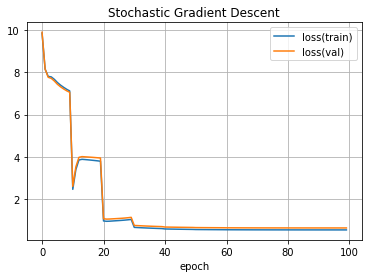

In [172]:
plt.plot(loss_train_history, label="loss(train)")
plt.plot(loss_val_history, label="loss(val)")
plt.legend()
plt.grid(True)
plt.xlabel("epoch")
plt.title("Stochastic Gradient Descent")

Text(0.5, 1.0, 'Stochastic Gradient Descent')

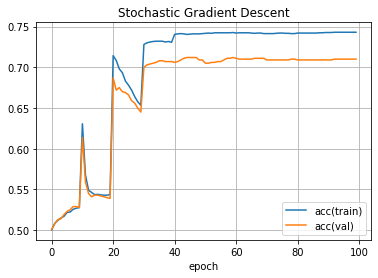

In [174]:
plt.plot(acc_train_list, label="acc(train)")
plt.plot(acc_val_list, label="acc(val)")
plt.legend()
plt.grid(True)
plt.xlabel("epoch")
plt.title("Stochastic Gradient Descent")